In [18]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns

import fnmatch
import glob
import dropbox

!ln -s /Users/matthiashugli/Virtualenvs/youth-base/youth-base/config.py config.py
from config import dbx_token
dbx = dropbox.Dropbox(dbx_token)

ln: config.py: File exists


In [19]:
sns.set(font='Meiryo', style='white')

In [20]:
path = '/Users/matthiashugli/Dropbox/bucket/super-league-stats/*'
path2 = '/Users/matthiashugli/Dropbox/bucket/super-league-stats/raw_baumann_fbref_saison20-21.csv'

df = pd.DataFrame()
for filename in glob.glob(path):
    #print(filename)
    file = pd.read_csv(filename, header=0, delimiter=',', low_memory=False)
    file.insert(0, 'filename', filename)
    df = df.append(file)

In [21]:
df.columns = df.columns.str.lower()

In [22]:
df[['source', 'file']] = df.filename.apply(lambda x: pd.Series(str(x).split('raw_')))
df[['goalkeeper', 'split6']] = df.file.apply(lambda x: pd.Series(str(x).split('_fbref')))
df['goalkeeper'] = df.goalkeeper.map(lambda x: x[0].upper() + x[1:])
df = df.drop(columns=['filename', 'source', 'file', 'split6'])
df = df.dropna(how='all')
df.goalkeeper = df.goalkeeper.astype('category')

In [23]:
# Exception Von Ballmoos
df['goalkeeper'] = df.goalkeeper.apply(lambda x: 'Von Ballmoos' if fnmatch.fnmatch(x, 'Vonballmoos') else x)

In [24]:
df['shots_faced'] = df.saves + df.ga
super_league_stats_20_21 = df[(df.comp == 'Super League') & (df.date <= '2021-07-01')]
super_league_stats_21_22 = df[(df.comp == 'Super League') & (df.date >= '2021-07-01')]

In [25]:
#shots_saves = df.groupby('goalkeeper')['sota', 'saves', 'ga'].sum().reset_index()
#shots_saves = df.groupby('goalkeeper').agg({'sota': ['sum', 'mean'], 'saves': ['sum'], 'ga': ['sum']}).reset_index()
shots_saves_20_21 = super_league_stats_20_21.groupby('goalkeeper').agg(shots_faced=('shots_faced', 'sum'), shots_faced_mean=('shots_faced', 'mean'), saves=('saves', 'sum'), goals=('ga', 'sum')).reset_index()
shots_saves_20_21['save_perc'] = shots_saves_20_21.saves / shots_saves_20_21.shots_faced * 100

In [30]:
shots_saves_20_21 = shots_saves_20_21.dropna()
print(shots_saves_20_21)

      goalkeeper  shots_faced  shots_faced_mean  saves  goals  save_perc
0        Baumann        120.0          4.444444   91.0   29.0  75.833333
1        Brecher        167.0          4.638889  110.0   57.0  65.868263
2        Büchel        151.0          4.314286   96.0   55.0  63.576159
3           Diaw        155.0          4.558824  105.0   50.0  67.741935
4         Fayulu         82.0          5.466667   58.0   24.0  70.731707
5   Fickentscher        111.0          5.285714   76.0   35.0  68.468468
6          Frick        152.0          4.606061  100.0   52.0  65.789474
7        Lindner        143.0          4.612903   97.0   46.0  67.832168
9        Müller        145.0          4.264706   90.0   55.0  62.068966
10        Osigwe         47.0          5.222222   34.0   13.0  72.340426
12  Von Ballmoos         90.0          2.903226   68.0   22.0  75.555556
13          Zigi        147.0          4.200000  100.0   47.0  68.027211


In [31]:
team_colors = ['black', 'white', 'red', 'white', 'white', 'white', 'red', 'blue', 'blue', 'black', 'yellow', 'green']
outline_colors = ['black', 'blue', 'red', 'blue', 'blue', 'red', 'blue', 'red', 'blue', 'black', 'black', 'green']

label_xpos = [0.08, -0.05, -0.05, -0.3, -0.05, -0.05, -0.3, 0.05, -0.05, -0.05, -0.05, -0.05]
label_ypos = [0.05, 0.5, 0.5, -0.6, 0.5, 0.5, -0.6, 0.2, 0.5, 0.5, 0.5, 0.5]
goalkeeper = shots_saves_20_21.goalkeeper.tolist()
color_dict = dict(zip(goalkeeper, team_colors))

In [33]:
fig = plt.figure(figsize=[12,12])
kwargs = {'palette': team_colors, 'edgecolor': outline_colors, 'linewidth': 4}

graph = sns.scatterplot(x='shots_faced_mean', y='save_perc', s=400, data=shots_saves_20_21, legend=False, hue='goalkeeper', **kwargs)

for i in range(shots_saves_20_21.shape[0]):
    plt.text(x=shots_saves_20_21.shots_faced_mean[i]+label_xpos[i], 
        y=shots_saves_20_21.save_perc[i]+label_ypos[i], 
        s=shots_saves_20_21.goalkeeper[i], 
        fontsize=20,
        bbox=dict(facecolor='gray', alpha=0))

#sns.despine()
graph.axhline(shots_saves_20_21.save_perc.mean(), color='#78909C')
graph.axvline(shots_saves_20_21.shots_faced_mean.mean(), color='#78909C')

plt.xlim(shots_saves_20_21.shots_faced_mean.mean()-2, shots_saves_20_21.shots_faced_mean.mean()+2)

#plt.title('Super League 2020 / 2021 Torhüter Abwehrquote \n Nur Daten von Torhüter mit 9 Spielen oder mehr, Quelle fbref.com', fontsize=24)
plt.xlabel('Schüsse aufs Tor pro Spiel', fontsize=20)
plt.ylabel('Abwehrquote in %', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig.text(0.5, 1, 'Super League 2020 / 2021 Torhüter Abwehrquote', ha='center', fontsize=32, fontweight='bold')
fig.text(0.5, 0.95, 'Daten von Torhüter mit mehr als 8 Spielen in der Super League', ha='center', fontsize=24)
fig.text(0.12, 0.001, 'Quelle fbref.com', ha='left', fontsize=16)
fig.text(0.9, 0.001, 'Grafik @huegli_matthias', ha='right', fontsize=16)

plt.savefig('SuperLeague20_21_GK_SavePercentage.png')
plt.show()


ValueError: The palette list has the wrong number of colors.

<Figure size 864x864 with 0 Axes>

# Analyse Noam Baumann

In [12]:
baumann = super_league_stats[super_league_stats.goalkeeper == 'Baumann']
baumann = baumann[['date', 'shots_faced', 'ga', 'saves']]
baumann = baumann.dropna(how='all')
baumann['year_month'] = pd.to_datetime(baumann['date']).dt.to_period('M')


print(baumann)

          date  shots_faced   ga  saves year_month
0   2020-10-24          6.0  0.0    6.0    2020-10
1   2020-11-07          3.0  0.0    3.0    2020-11
2   2020-11-22          4.0  1.0    3.0    2020-11
3   2020-11-29          1.0  0.0    1.0    2020-11
4   2020-12-13          5.0  1.0    4.0    2020-12
5   2020-12-16          4.0  0.0    4.0    2020-12
6   2020-12-19          6.0  2.0    4.0    2020-12
7   2020-12-23          3.0  0.0    3.0    2020-12
8   2021-01-17          3.0  1.0    2.0    2021-01
9   2021-01-20          4.0  2.0    2.0    2021-01
10  2021-01-24          3.0  0.0    3.0    2021-01
11  2021-01-31          5.0  2.0    3.0    2021-01
12  2021-02-03          2.0  1.0    1.0    2021-02
13  2021-02-10          7.0  1.0    6.0    2021-02
14  2021-02-14          9.0  3.0    6.0    2021-02
15  2021-02-17          4.0  1.0    3.0    2021-02
16  2021-02-21          9.0  3.0    6.0    2021-02
17  2021-02-28          6.0  2.0    4.0    2021-02
18  2021-03-04          5.0  0.

In [13]:
baumann['save_perc'] = baumann.saves / baumann.shots_faced
baumann['league_average'] = super_league_stats.saves.sum() / super_league_stats.shots_faced.sum()
baumann['performance_to_average'] = baumann.save_perc - baumann.league_average

print(baumann)

          date  shots_faced   ga  saves year_month  save_perc  league_average  \
0   2020-10-24          6.0  0.0    6.0    2020-10   1.000000        0.678808   
1   2020-11-07          3.0  0.0    3.0    2020-11   1.000000        0.678808   
2   2020-11-22          4.0  1.0    3.0    2020-11   0.750000        0.678808   
3   2020-11-29          1.0  0.0    1.0    2020-11   1.000000        0.678808   
4   2020-12-13          5.0  1.0    4.0    2020-12   0.800000        0.678808   
5   2020-12-16          4.0  0.0    4.0    2020-12   1.000000        0.678808   
6   2020-12-19          6.0  2.0    4.0    2020-12   0.666667        0.678808   
7   2020-12-23          3.0  0.0    3.0    2020-12   1.000000        0.678808   
8   2021-01-17          3.0  1.0    2.0    2021-01   0.666667        0.678808   
9   2021-01-20          4.0  2.0    2.0    2021-01   0.500000        0.678808   
10  2021-01-24          3.0  0.0    3.0    2021-01   1.000000        0.678808   
11  2021-01-31          5.0 

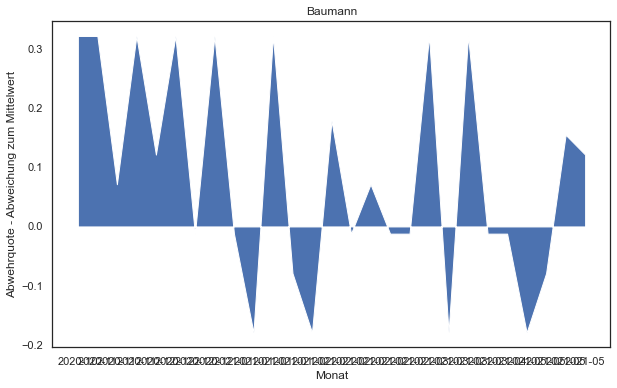

In [14]:
sns.set_theme(style='white')

x = baumann.year_month.to_list()
xi = list(range(len(x)))
fig, ax = plt.subplots(figsize=[10,6])
ax.stackplot(xi, baumann.performance_to_average)
ax.fill
plt.xticks(xi, x)

ax.set(xlabel='Monat', ylabel='Abwehrquote - Abweichung zum Mittelwert', title='Baumann')
#sns.stackplot(data=baumann, x='date', y='performance_to_average')

plt.show()

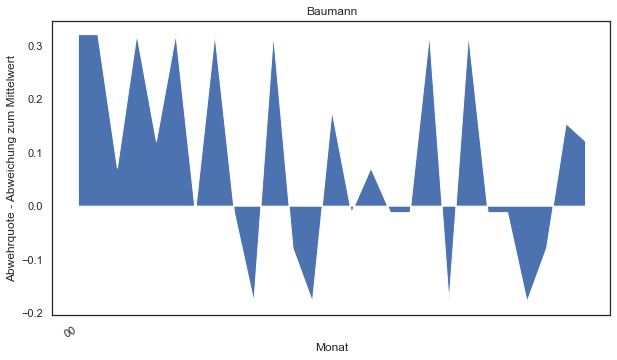

In [15]:
sns.set_theme(style='white')

years = mdates.YearLocator()
months = mdates.MonthLocator()
years_fmt = mdates.DateFormatter('%M')

fig, ax = plt.subplots(figsize=[10,6])
ax.stackplot('date', 'performance_to_average', data = baumann)
ax.fill
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

ax.format_xdata = mdates.DateFormatter('%M')
fig.autofmt_xdate()

ax.set(xlabel='Monat', ylabel='Abwehrquote - Abweichung zum Mittelwert', title='Baumann')
#sns.stackplot(data=baumann, x='date', y='performance_to_average')

plt.show()